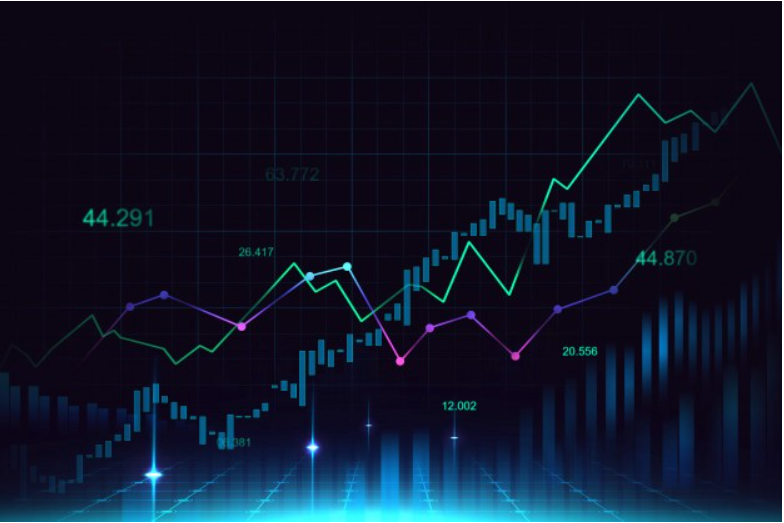

## Introduction: 
Stock market prediction and analysis are some of the most difficult jobs to complete. There are numerous causes for this, including market volatility and a variety of other dependent and independent variables that influence the value of a certain stock in the market. These variables make it extremely difficult for any stock market expert to anticipate the rise and fall of the market with great precision.

However, with the introduction of Machine Learning and its strong algorithms, the most recent market research and Stock Market Prediction advancements have begun to include such approaches in analyzing stock market data.

- Let's go on a journey to solve this problem.


#### Numerical Data is from (finance.yahoo.com)

## 1. Import Libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost 
import lightgbm 


## 2. Load the Textual Data

In [ ]:
df_text = pd.read_csv("../input/india-headlines-news-dataset/india-news-headlines.csv")
df_text.head()

## 3. Handling with Textual Data:

Much of headline_category is unknown! so we can drop this column.

In [ ]:
df_text.drop(0, inplace=True)
df_text.drop('headline_category', axis = 1, inplace=True)
df_text.head()



In [ ]:
df_text["publish_date"] = pd.to_datetime(df_text["publish_date"],format='%Y%m%d')
df_text.info()


In [ ]:
df_text.shape

In [ ]:
df_text.isnull().sum()


In [ ]:
df_text['headline_text'] = df_text.groupby(['publish_date']).transform(lambda x : ' '.join(x)) 
df_text = df_text.drop_duplicates() 
len(df_text)

In [ ]:
df_text

In [ ]:
df_text.reset_index(inplace=True,drop=True)


#### Remove Unwanted Characters from the head_line text


In [ ]:
df_text.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
df_text["headline_text"].head(5)


Now we need to get the subjectivity and polarity so we will make a function to get them.

In [ ]:
def Subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def Polarity(text):
  return  TextBlob(text).sentiment.polarity

df_text['Subjectivity'] = df_text['headline_text'].apply(Subjectivity)
df_text['Polarity'] = df_text['headline_text'].apply(Polarity)
df_text



### Visualize a Polarity and Subjectivity


In [ ]:
plt.figure(figsize = (10,6))
df_text['Polarity'].hist(color = 'green')


In [ ]:
plt.figure(figsize = (10,6))
df_text['Subjectivity'].hist(color = 'blue')


### Performing Sentiment Analysis over the news Headlines




In [ ]:
snt = SentimentIntensityAnalyzer()



In [ ]:
df_text['Compound'] = [snt.polarity_scores(v)['compound'] for v in df_text['headline_text']]
df_text['Negative'] = [snt.polarity_scores(v)['neg'] for v in df_text['headline_text']]
df_text['Neutral'] = [snt.polarity_scores(v)['neu'] for v in df_text['headline_text']]
df_text['Positive'] = [snt.polarity_scores(v)['pos'] for v in df_text['headline_text']]
df_text


## 4. Load the Numerical Data 

In [ ]:
df_num = pd.read_csv("../input/numerical-stock-prices/QMCI.csv")
df_num.head()


## 5. Handling with Numerical Data

All the things that are going to happen in this data must be related to time to this index.

In [ ]:
df_num["Date"] = pd.to_datetime(df_num["Date"],format='%Y-%m-%d')
df_num.info()


Let's see how the data will be like:

In [ ]:
df_num

In [ ]:
df_num.describe()


In [ ]:
#check for null values
df_num.isnull().sum()


In [ ]:
plt.figure(figsize=(10,6))
df_num['Close'].plot()
plt.ylabel('QMCI')


### Plotting Moving Average

In [ ]:
close = df_num['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10,6))
df_num['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()



In [ ]:
#split the data to train and test
train = df_num[:200]
test = df_num[200:]


### Rolling mean and Standard Deviation


In [ ]:
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])


In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 


## Using auto arima to make predictions using log data


In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])


#### Visualize Prediction

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('QMCI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')


In [ ]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)


## 6. Merge the Numerical and Textual Data


In [ ]:
merge = df_text
merge

In [ ]:
data = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data


In [ ]:
X = data[:252]
y = df['Close']


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape


## 7. Apply Models

### RandomForestRegressor Model

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)


In [ ]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))


### DecisionTreeRegressor Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))


### XGBRegressor Model

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))


## 8. Conclusion:
we can see that RandomForestRegressor shows a better performance than the others